**Chapter 7: Assumptions**

Just like before, we are assuming some things are true if we fit a model. Therefore, we need to **check our assumptions** before we use a model to predict values in the future (to make sure it's actually a good model)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

df = pd.read_csv('https://www.ishelp.info/data/insurance.csv')

for col in df:  
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns=[col], prefix=col, drop_first=True)

# Set label and features
y = df['charges']                    
X = df.select_dtypes(np.number).assign(const=1)
X = X.drop(columns=['charges'])

# Run the multiple linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())  # View results

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.69
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           8.80e-37
Time:                        08:42:20   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          239.9945     22.289     10.767      0.0

**Assumptions:**
* **Normality**: Omnibus and Jarque-Bera (safe: p-value *high*)
    * *Residuals* need to be normally distributed
    * p < 0.05 means **problem with normality**
* **Multicollinearity**: Are there strong relationships between any two variables, to the point where an increase/decrease in one will strongly affect the other?
    * *Condition Number (Cond. No.)*: safe: < 10, okay: < 30, but can go as high as 100 (**NOTE: VIFs are more reliable**)
    * *VIF:* below 3 (great), 5 (good), 10 (okay)
    * *Tolerance:* above 0.1 (good enough) or 0.2 (better) *(Some sources say cutoff should be 0.25)*
* **Autocorrelation**: How dependent are the variables on *time*? This is a whole other set of statistical analysis called *time series*
    * *Durban-Watson*: Safe between 1 and 2

**Theory**
* VIF: 1 / (1 - R^2)
* Tolerance: 1 - R^2

R^2 is a correlation of one variable based on the other variables in the model

**Residuals**: Difference between actual values and those predicted by our model.

What does this mean??
* **Actual**: Charges made to insurance by each person
* **Predicted**: If we plug-and-chug age, bmi, etc., for each person in our dataset into the model we created, what does our model say the charges to insurance would be?

We subtract one from the other to get a difference between the two. It's like rechecking to see how well our model would work if we had the same people, same data, but we wanted to predict their charges to insurance.

In [35]:
df_insample = pd.DataFrame({'Actual':df['charges'], 
                            'Predicted':model.fittedvalues, 
                            'Residuals (Error)':df['charges'] - model.fittedvalues})

df_insample.head(10)

,Actual,Predicted,Residuals (Error)
0,16884.92400,6908.777533,9976.146467
1,1725.55230,9160.977061,-7435.424761
2,4449.46200,12390.946918,-7941.484918
3,21984.47061,8543.527095,13440.943515
4,3866.85520,10354.147396,-6487.292196
5,3756.62160,9071.411158,-5314.789558
6,8240.58960,15771.234831,-7530.645231
7,7281.50560,12804.138689,-5522.633089
8,6406.41070,12955.328269,-6548.917569
9,28923.13692,16064.459249,12858.677671


**Pairplots**: When using multiple variables to predict another value, we NEED to make sure the variables don't have any direct relationship to each other! This means we would need to include this relationship in our model (such as an *interaction*)

If we run a pairplot, we can quickly see if any individual variables have a relationship with each other. If you see a pattern, such as a *line, groupings, curves, etc.*, then there could be a relationship between two individual variables.

*We DON'T want patterns, but if we see it, we need to address it in our model.* For now, just learn to recognize potential issues.

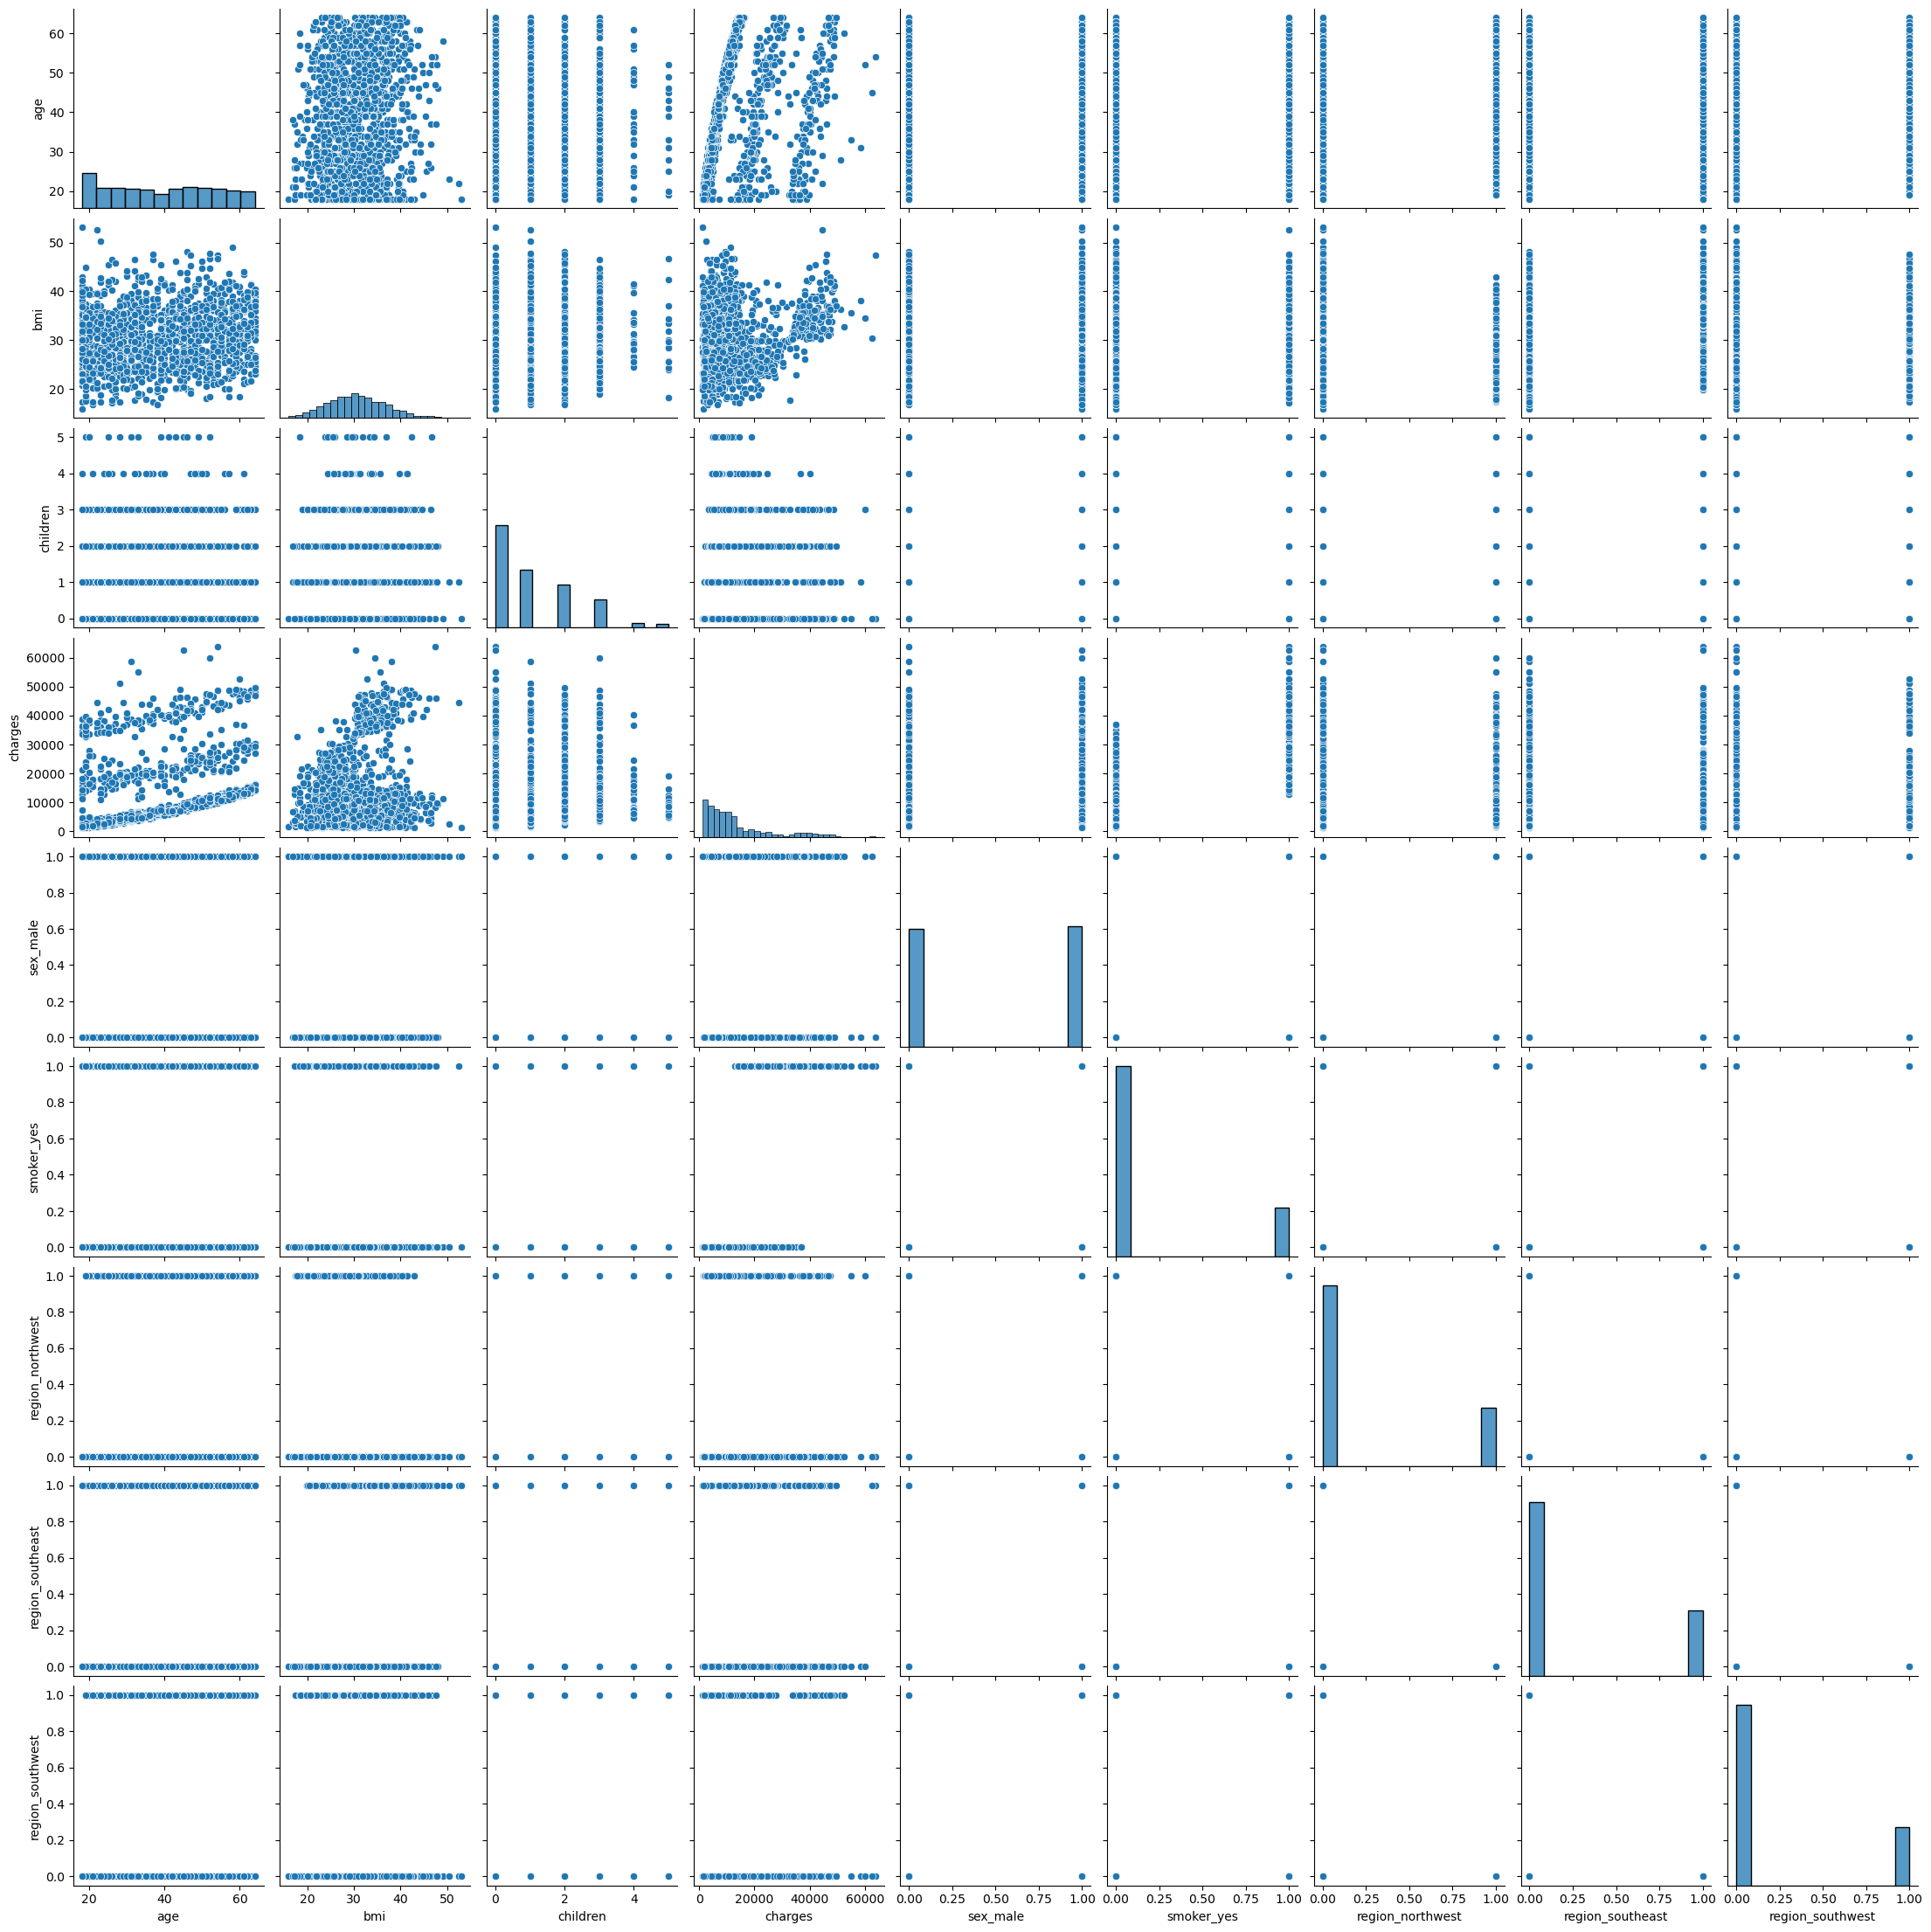

In [36]:
sns.pairplot(df);

**Normality**: We want residuals to be normally distributed. We can check this easily with the following two plots:
1. Residuals vs. Fitted Values (Predicted by the model)
2. Probability Plot (This is MUCH easier to check)

**Residuals vs. Fitted Values**: The following should be scattered nicely, but it's not. We see some patterns. **Uh oh...**

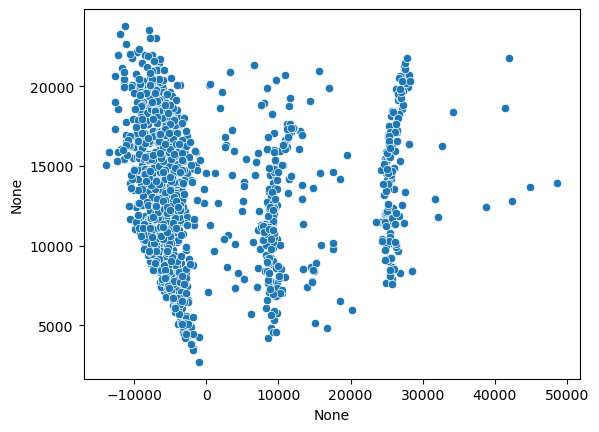

In [37]:
pred_val = model.fittedvalues.copy()
true_val = df['charges'].values.copy()
residual = true_val - pred_val

ax = sns.scatterplot(x=residual, y=pred_val)

**Probability Plot**: We want to see our **blue dots follow the red straight line as much as possible**, and we DEFINITELY don't want to see any patterns. (Refer to links in Canvas for potential patterns and what they could indicate).

Often, we might see the top and bottom parts trail away from the red line, which is an indicator that our normality assumption is NOT met.

The following plot shows a clear pattern away from the red line. We have an issue.

0.7521581906013646

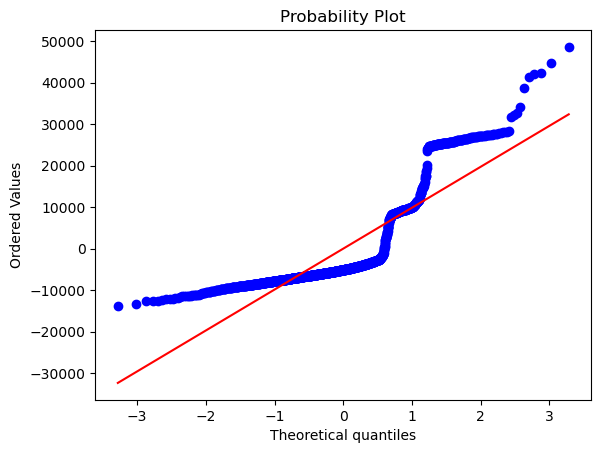

In [38]:
import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

**Omnibus and JB Tests**: Go back up to our output. Remember, these tests are testing **if there is an issue with normality.**

Therefore, if the p-value is really low, then what we are testing for is found! What are we testing for? Problems with normality!

We have an extremely low p-value. THEREFORE... there's a problem with normality!

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

    Feature        VIF
0       age   1.013816
1       bmi   1.012152
2  children   1.001874
3     const  31.954929


In [41]:
import statsmodels.api as sm

# Create a blank DataFrame to store the results
df_vif = pd.DataFrame(columns=['VIF', 'Tolerance'])
df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns, drop_first=True)


df = df.astype(float)

for col in df.drop(columns=['charges']):
  y = df[col]
  X = df.drop(columns=[col, 'charges']).assign(const=1)
  
  r_squared = sm.OLS(y, X).fit().rsquared

  if r_squared < 1: # Prevent division by zero runtime error
    df_vif.loc[col] = [1/(1 - r_squared), 1 - r_squared]
  else:
    df_vif.loc[col] = ['infinity', 1 - r_squared]

df_vif.sort_values(by=['VIF'], ascending=False)

,VIF,Tolerance
region_southeast,1.652230,0.605243
region_southwest,1.529411,0.653846
region_northwest,1.518823,0.658405
bmi,1.106630,0.903645
age,1.016822,0.983456
smoker_yes,1.012074,0.988070
sex_male,1.008900,0.991178
children,1.004011,0.996005


The book explains a little more about the Multicollinearity and Autocorrelation assumptions and this example. However, we can look at the VIF and Tolerance levels above, and refer back to what's considered "good" above.

Looks like our Multicollinearity and Autocorrelation assumptions are met! **So, we're at least good there!**

**NEED TO FIX NORMALITY ISSUE**

This is where transformations come into play. Look back at the pairplot--*charges* is highly skewed. Refer to our section on skewness: the best **transformation** to fix the skewness on charges is ln(charges).

*Create a new column (or simply change the original column if you're pretty confident) to the tranformed ln(charges).*

In [ ]:
df['charges_ln'] = np.log(df['charges'])
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges_ln
0,19.0,27.900,0.0,16884.92400,0.0,1.0,0.0,0.0,1.0,9.734176
1,18.0,33.770,1.0,1725.55230,1.0,0.0,0.0,1.0,0.0,7.453302
2,28.0,33.000,3.0,4449.46200,1.0,0.0,0.0,1.0,0.0,8.400538
3,33.0,22.705,0.0,21984.47061,1.0,0.0,1.0,0.0,0.0,9.998092
4,32.0,28.880,0.0,3866.85520,1.0,0.0,1.0,0.0,0.0,8.260197
...,...,...,...,...,...,...,...,...,...,...
1333,50.0,30.970,3.0,10600.54830,1.0,0.0,1.0,0.0,0.0,9.268661
1334,18.0,31.920,0.0,2205.98080,0.0,0.0,0.0,0.0,0.0,7.698927
1335,18.0,36.850,0.0,1629.83350,0.0,0.0,0.0,1.0,0.0,7.396233
1336,21.0,25.800,0.0,2007.94500,0.0,0.0,0.0,0.0,1.0,7.604867


Repeat the same stepwise variable selection (make sure to drop *charges* in your analysis) with *charges_ln* as your dependent/response variable. Does this fix the issue?

In [ ]:
y = df['charges_ln']                    
X = df.select_dtypes(np.number).assign(const=1)
X = X.drop(columns=['charges_ln', 'charges','region_northwest'])

# Run the multiple linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())  # View results

                            OLS Regression Results                            
Dep. Variable:             charges_ln   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     626.7
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        08:42:09   Log-Likelihood:                -810.20
No. Observations:                1338   AIC:                             1636.
Df Residuals:                    1330   BIC:                             1678.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0346      0.001  

0.8370289563345668

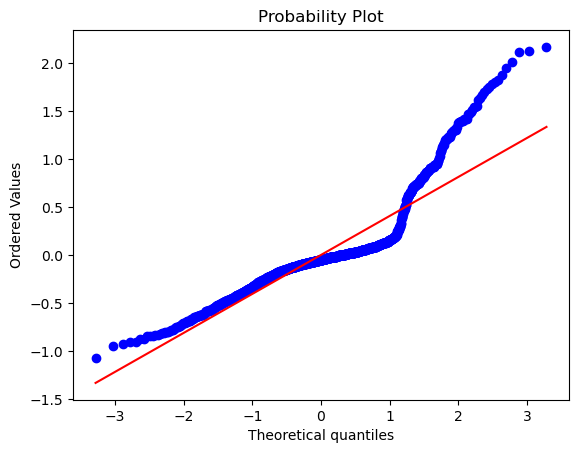

In [ ]:
pred_val = model.fittedvalues.copy()
true_val = df['charges_ln'].values.copy()
residual = true_val - pred_val

import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

Did we fix the problem with normality? **Not really.** What else could be the issue? Notice that *age* is not normally distributed either. 

However, after trying multiple transformations, including binning, the problem with normality was never fixed until *age* was dropped altogether. 

In [31]:
# Set label and features
y = df['charges_ln']                    
X = df.select_dtypes(np.number).assign(const=1)
X = X.drop(columns=['charges', 'charges_ln', 'region_northwest','age','region_southwest'])

# Run the multiple linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())  # View results

                            OLS Regression Results                            
Dep. Variable:             charges_ln   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     256.6
Date:                Tue, 28 Jan 2025   Prob (F-statistic):          3.40e-192
Time:                        08:42:09   Log-Likelihood:                -1334.5
No. Observations:                1338   AIC:                             2681.
Df Residuals:                    1332   BIC:                             2712.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
bmi                  0.0224      0.003  

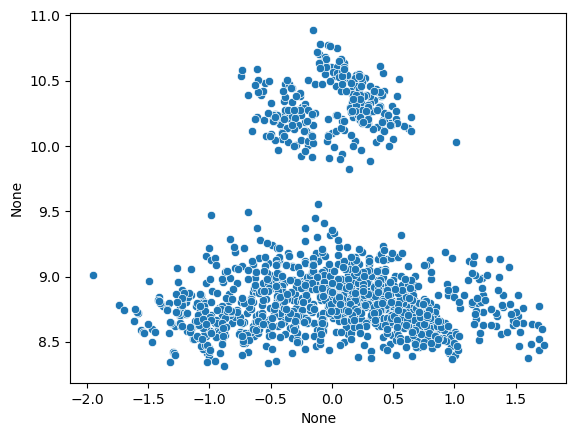

In [ ]:
pred_val = model.fittedvalues.copy()
true_val = df['charges_ln'].values.copy()
residual = true_val - pred_val

ax = sns.scatterplot(x=residual, y=pred_val)

0.9954761712671096

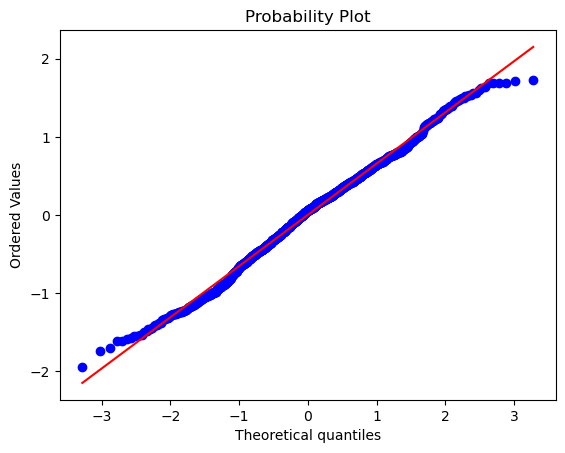

In [ ]:
import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

There's still some patterns in the plots, but the Omnibus/JB tests are satisfied. 

**KNOW THY DATA**: in BUSA 321, was there a strong correlation between age and charges on insurance? Not really. So, even if it is coming up as *significant* in our analysis, the problem with normality makes this unreliable. We use our brainpower as analysts, and know our data well enough to realize that age can be dropped from the model. 

**What if normality cannot be fixed?** Try any of the following:

* **Drop** the problematic variable, as done above
* Look for extreme **outliers** and remove them
* Look for **potential issues** with the data itself 
* **Non-Parametric** methods, models, or analysis that does not rely on normality, as we will be learning through the rest of the course